In [170]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn import metrics

In [171]:
import os
from os.path import expanduser
home = expanduser("~")
os.chdir(os.path.join(home, 'Documents', 'Trainings', 'inpost'))
print('Current working directory set to:')
os.getcwd()

Current working directory set to:


'/Users/joannawojdylo/Documents/Trainings/inpost'

In [172]:
RAW_DIR = os.path.join(os.getcwd(), 'data', 'raw')
csv_name = "simulated_ts.csv"

In [173]:
RAW_DIR = os.path.join(os.getcwd(), 'data', 'raw')
csv_name = "simulated_ts.csv"

In [174]:
data_all = pd.read_csv(os.path.join(RAW_DIR, csv_name), delimiter=";")

In [175]:
data_all['y'] = data_all['y'].str.replace(',', '.')
data_all['y'] = pd.to_numeric(data_all['y'])
data_all.set_index("time id", inplace=True)
data_all.head()

,y
time id,
1,105.928958
2,22.375814
3,230.063647
4,111.713361
5,8.710064


In [176]:
train_test_split_value = 489
data_train=data_all[:train_test_split_value]
data_test=data_all[train_test_split_value:]

In [177]:
DEFAULT_COLUMN_NAME = 'y'
STANDARDIZED_COLUMN_NAME = 'standardized y'

### I'll use standardization on data for better SVR performance

In [181]:
def fit_standard_scaler_to_df_column(df: pd.DataFrame, column: str = DEFAULT_COLUMN_NAME):
    standard_scaler = StandardScaler().fit(df[[column]])
    return standard_scaler

In [179]:
def apply_scaler_df_column(scaler, dataframe: pd.DataFrame, column: str = DEFAULT_COLUMN_NAME, standardized_column_name: str = STANDARDIZED_COLUMN_NAME) -> pd.DataFrame:
    df = dataframe.copy()
    df[[standardized_column_name]] = scaler.transform(df[[column]])
    return df

In [180]:
scaler = fit_standard_scaler_to_df_column(data_train)
data_train = apply_scaler_df_column(scaler, data_train, standardized_column_name=DEFAULT_COLUMN_NAME)

<class 'sklearn.preprocessing._data.StandardScaler'>


### Preparing the time series for SVR model - sliding window approach

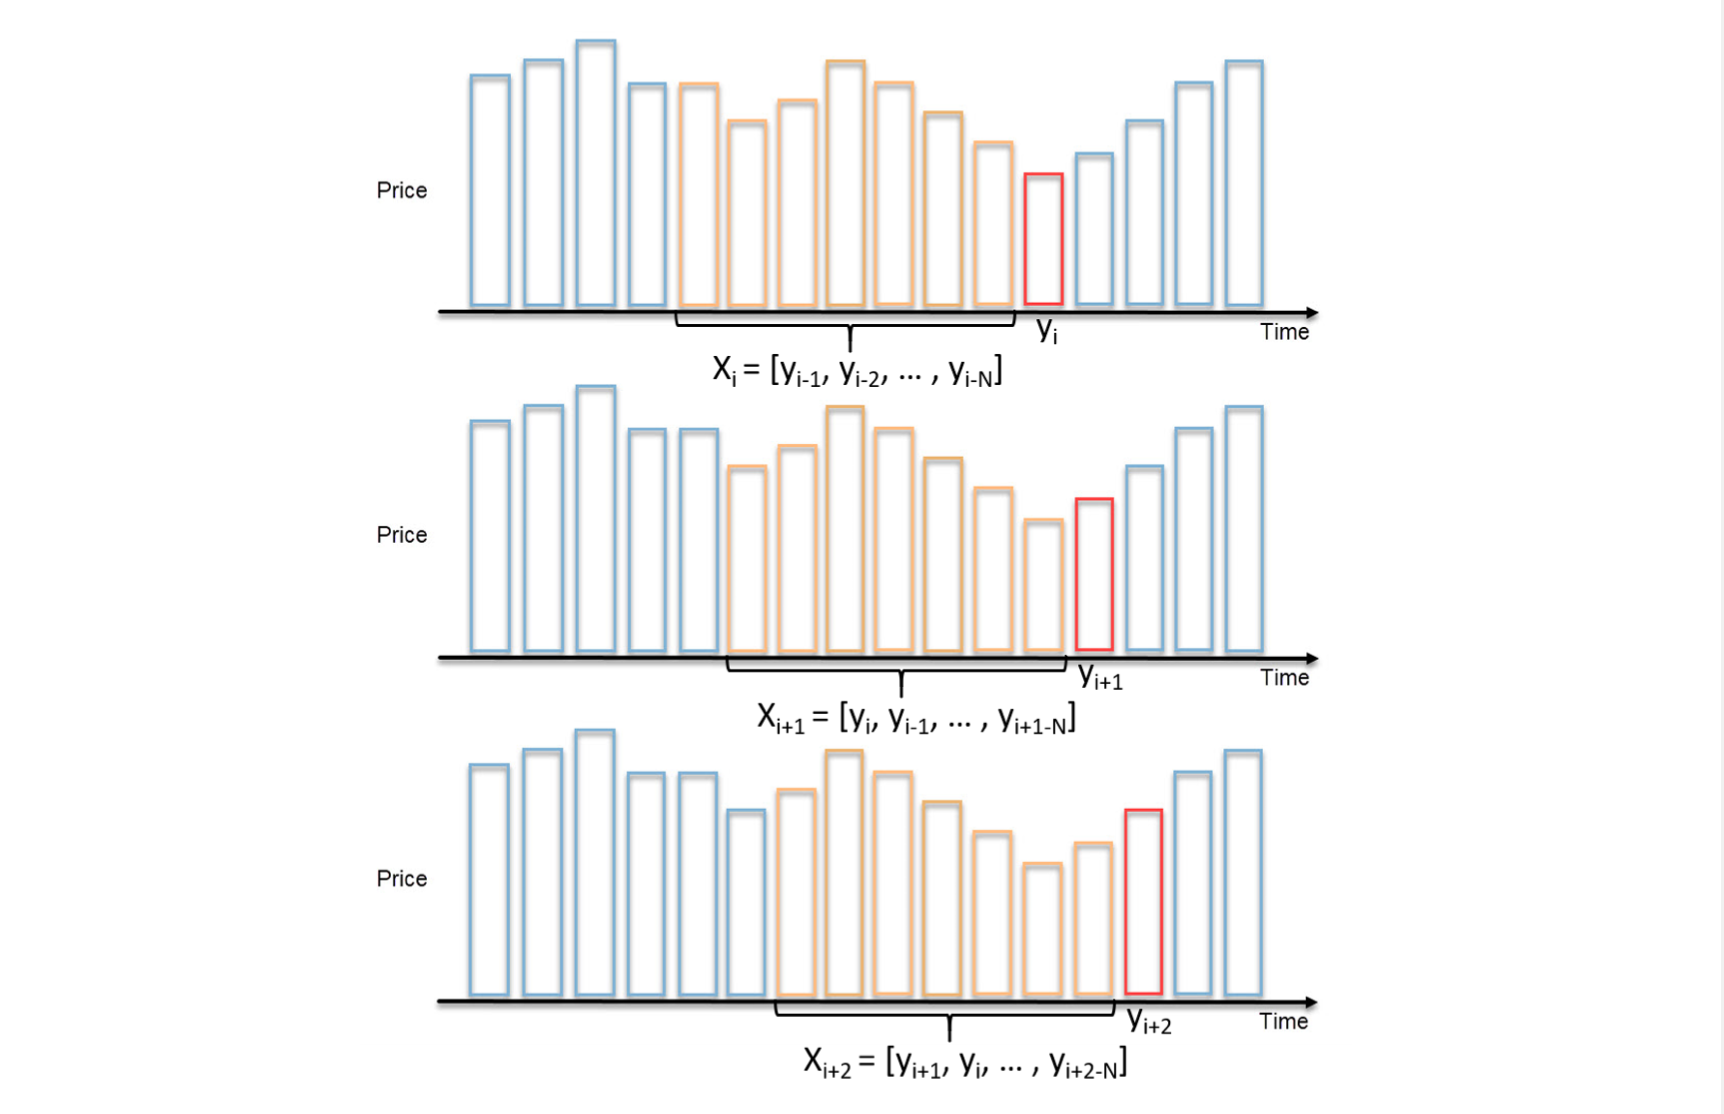

In [182]:
def create_df_with_lags(dataframe: pd.DataFrame, N: int, column: str = DEFAULT_COLUMN_NAME) -> pd.DataFrame:
    df = dataframe.copy()
    for i in range(N):
        df['Lag' + str(i + 1)] = df[column].shift(i + 1)
    df = df.dropna()
    return df  # we are getting here dataframe with price, Lag1, Lag2, ... , LagN columns

In [183]:
number_of_lags = 10 # I choose this parameter "by hand" this time, should be explored more carefully
data_train_with_lags = create_df_with_lags(data_train, number_of_lags, column=DEFAULT_COLUMN_NAME)
data_train_with_lags

,y,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10
time id,,,,,,,,,,,
11,-1.737729,-1.889093,-1.210542,-1.238766,-1.402396,-1.767050,-1.850065,-1.697997,-1.523271,-1.829890,-1.706536
12,-1.805192,-1.737729,-1.889093,-1.210542,-1.238766,-1.402396,-1.767050,-1.850065,-1.697997,-1.523271,-1.829890
13,-1.939077,-1.805192,-1.737729,-1.889093,-1.210542,-1.238766,-1.402396,-1.767050,-1.850065,-1.697997,-1.523271
14,-1.834933,-1.939077,-1.805192,-1.737729,-1.889093,-1.210542,-1.238766,-1.402396,-1.767050,-1.850065,-1.697997
15,-1.834343,-1.834933,-1.939077,-1.805192,-1.737729,-1.889093,-1.210542,-1.238766,-1.402396,-1.767050,-1.850065
...,...,...,...,...,...,...,...,...,...,...,...
485,1.968764,1.326851,1.299560,1.432885,1.254568,0.962137,1.030268,1.098687,1.191232,0.794100,1.011405
486,1.681082,1.968764,1.326851,1.299560,1.432885,1.254568,0.962137,1.030268,1.098687,1.191232,0.794100
487,1.829756,1.681082,1.968764,1.326851,1.299560,1.432885,1.254568,0.962137,1.030268,1.098687,1.191232


In [186]:
def create_numpy_arrays_with_lags(df_with_lags: pd.DataFrame, main_column: str = DEFAULT_COLUMN_NAME) -> tuple[np.ndarray, np.ndarray]:
    y = df_with_lags[main_column].values
    X = df_with_lags.iloc[:, 1:].values
    return X, y

In [187]:
X, y = create_numpy_arrays_with_lags(data_train_with_lags, main_column=DEFAULT_COLUMN_NAME)

In [188]:
X.shape

(479, 10)

In [189]:
y.shape

(479,)

### Additional split to get validation set

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Using grid search to find best hyperparameters in our case

In [193]:
def fit_best_SVR_model_using_GridSearch(X, y):
    param_grid = {'C': [0.1, 1, 10, 50, 100, 500, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 1e-08, 1e-09, 1e-10],
                  'kernel': ['rbf']}

    svr_rbf = GridSearchCV(SVR(), param_grid, cv=5, refit=True, verbose=0)

    # fitting the model from grid search
    svr_rbf.fit(X, y)
    print(f'Chosen parameters: {svr_rbf.best_params_}')
    return svr_rbf

In [194]:
svr_model = fit_best_SVR_model_using_GridSearch(X_train, y_train)

Chosen parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


### Definition of some accuracy metrics to be used

In [161]:
def calculate_mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [162]:
def calculate_metrics(actual, pred):
    mse = metrics.mean_squared_error(actual, pred)
    print("MSE:", mse)
    rmse = np.sqrt(metrics.mean_squared_error(actual, pred))
    print("RMSE:", rmse)
    mae = metrics.mean_absolute_error(actual, pred)
    print("MAE:", mae)
    explained_variance_score = metrics.explained_variance_score(actual, pred)
    print("Explained variance score: ", explained_variance_score)
    mape = calculate_mape(actual, pred)
    print("MAPE: ", mape)

    correlation_matrix = np.corrcoef(actual, pred)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy ** 2
    print("R2:", r_squared)

    residuals = actual - pred
    residuals_mean = np.mean(residuals)
    residuals_std = np.std(residuals)
    print('Residuals mean: ', residuals_mean)
    print('Residuals sd: ', residuals_std)
    return None

### Let's validate our hyperparameters choice on the validation data

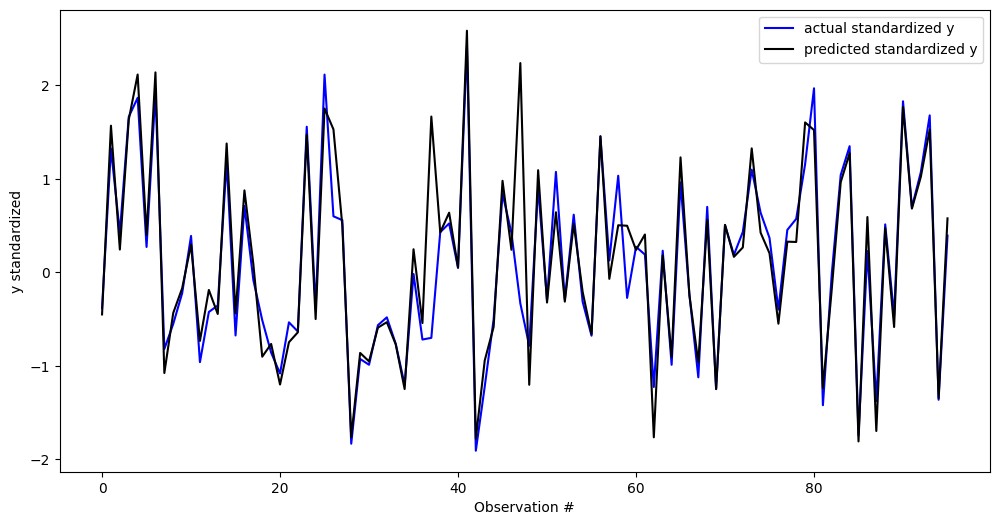

In [163]:
plt.figure(figsize = (12,6))
plt.plot(y_test, color= 'blue', label= 'actual standardized y')
plt.plot(svr_model.predict(X_test), color= 'black', label= 'predicted standardized y')

plt.xlabel('Observation #')
plt.ylabel('y standardized')
plt.legend()
plt.show()

In [164]:
print("Accuracy metrics obtained on the validation set:")
calculate_metrics(y_test, svr_model.predict(X_test))

Accuracy metrics obtained on the validation set:
MSE: 0.1789840574796533
RMSE: 0.4230650747575995
MAE: 0.21335433972303833
Explained variance score:  0.8135057031369365
MAPE:  70.69183845987304
R2: 0.8343777789005057
Residuals mean:  -0.05459808429227723
Residuals sd:  0.41952724187025886


### A recursive forecasting algorithm

In [195]:
def inverse_scaler_on_df_column(scaler, dataframe: pd.DataFrame, column: str = DEFAULT_COLUMN_NAME) -> pd.DataFrame:
    df = dataframe.copy()
    df[[column]] = scaler.inverse_transform(df[[column]])
    return df

In [196]:
def predict_future(known_dataframe: pd.DataFrame, lag: int,  model, days_ahead: int) -> pd.DataFrame:
    """
    known_dataframe in form of date(index) - value(column), column named as default 'prices'
    """
    X = create_numpy_arrays_with_lags(create_df_with_lags(known_dataframe, lag))[0]
    predicted_y = []
    indexes = []
    last_index = known_dataframe.index[-1]
    for i in range(0, days_ahead):
        new_prediction = model.predict(X[-1].reshape(1, -1))  # jeden dzien do przodu
        predicted_y.append(new_prediction)
        X = np.concatenate((X, np.append(new_prediction, X[-1][:-1]).reshape(1, -1)))
        last_index = last_index + 1
        indexes.append(last_index)

    predicted_dataframe = pd.DataFrame({DEFAULT_COLUMN_NAME: predicted_y, 'time id': indexes})
    predicted_dataframe = predicted_dataframe.set_index('time id')
    predicted_dataframe[DEFAULT_COLUMN_NAME] = predicted_dataframe[DEFAULT_COLUMN_NAME].astype(float)
    return predicted_dataframe

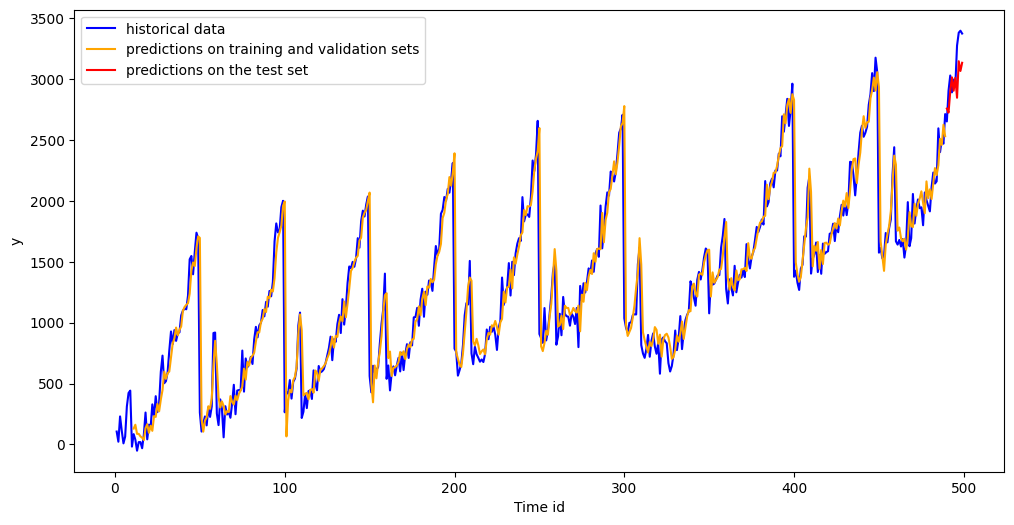

Accuracy metrics obtained from 1-day ahead forecast
MSE: 49305.49714369125
RMSE: 222.0484117117059
MAE: 192.49706700052866
Explained variance score:  0.4720592611885469
MAPE:  6.072404121755214
R2: 0.486598124895101
Residuals mean:  134.54391649393702
Residuals sd:  176.6449310853945
None


In [197]:
plt.figure(figsize=(12, 6))
plt.plot(data_all[DEFAULT_COLUMN_NAME], color='blue', label='historical data')

plt.plot(data_train.index[number_of_lags:], scaler.inverse_transform(svr_model.predict(X).reshape(-1, 1)), color='orange', label='predictions on training and validation sets')


data_all_scaled = apply_scaler_df_column(scaler, data_all, standardized_column_name=DEFAULT_COLUMN_NAME)
data_all_with_lags = create_df_with_lags(data_all_scaled, number_of_lags, column=DEFAULT_COLUMN_NAME)
X_all, y_all = create_numpy_arrays_with_lags(data_all_with_lags, main_column=DEFAULT_COLUMN_NAME)

plt.plot(data_test.index, scaler.inverse_transform(svr_model.predict(X_all).reshape(-1, 1))[-data_test.size:], color='red', label='predictions on the test set')

plt.xlabel('Time id')
plt.ylabel('y')
plt.legend()
plt.show()
print('Accuracy metrics obtained from 1-day ahead forecast')
print(calculate_metrics(data_test[DEFAULT_COLUMN_NAME].values, scaler.inverse_transform(svr_model.predict(X_all).reshape(-1, 1))[-data_test.size:].ravel()))


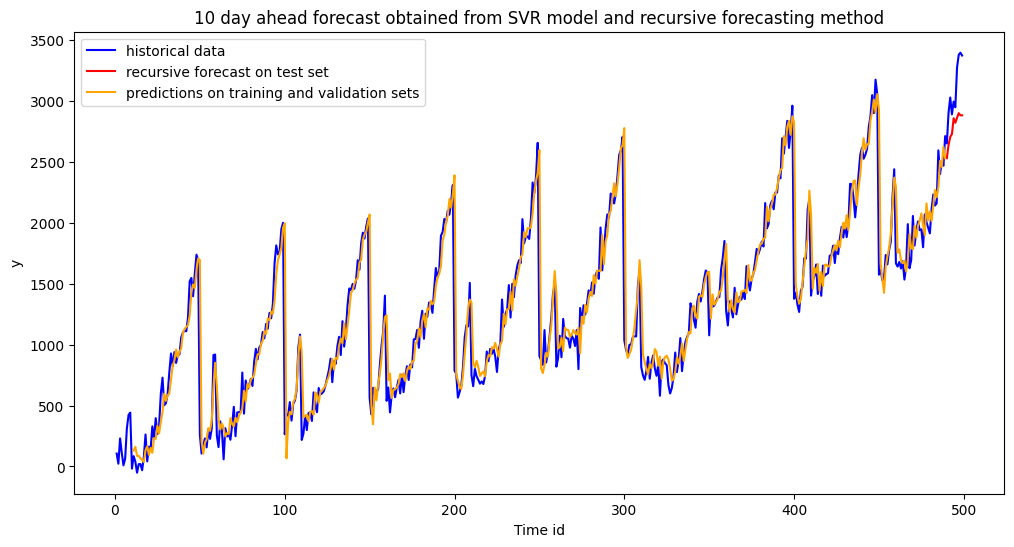

Accuracy metrics obtained from 10 day forecast using recursive forecasting method
MSE: 115621.61924045158
RMSE: 340.03179151434
MAE: 303.2714790302536
Explained variance score:  0.5998915067740129
MAPE:  9.531715797522839
R2: 0.7382124713655108
Residuals mean:  303.2714790302536
Residuals sd:  153.77915738894532
None


In [169]:
plt.figure(figsize=(12, 6))
plt.plot(data_all[DEFAULT_COLUMN_NAME], color='blue', label='historical data')
plt.plot(inverse_scaler_on_df_column(scaler, predict_future(data_train, number_of_lags, svr_model, number_of_days_ahead))[DEFAULT_COLUMN_NAME], color='red', label='recursive forecast on test set')
plt.plot(data_train.index[number_of_lags:], scaler.inverse_transform(svr_model.predict(X).reshape(-1, 1)), color='orange', label='predictions on training and validation sets')

        # plt.plot(dates_train, clf.predict(X_test), color= 'red', label= 'RBF model')
        # plt.plot(dates_test, scaler.inverse_transform(svr_rbf.predict(dates_test)), color= 'green', label= 'RBF model')
plt.xlabel('Time id')
plt.ylabel('y')
plt.title('10 day ahead forecast obtained from SVR model and recursive forecasting method')
plt.legend()
plt.show()

print("Accuracy metrics obtained from 10 day forecast using recursive forecasting method")
print(calculate_metrics(data_test[DEFAULT_COLUMN_NAME].values, inverse_scaler_on_df_column(scaler, predict_future(data_train, number_of_lags, svr_model, number_of_days_ahead))[DEFAULT_COLUMN_NAME]))